In [1]:
import os  

import matplotlib.pylab as plt
import numpy as np
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [9]:
IMG = '../../../img'

In [2]:
def plot_cost_accuracy(checkpoint):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot(checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [3]:
def show_data(data_sample):
    plt.imshow(
        data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE),
        cmap='gray')
    plt.title(f'y = {data_sample[1]}')

In [4]:
def plot_misclassified(model, dataset):
    count = 0
    for x, y in torch.utils.data.DataLoader(
            dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break 

In [5]:
IMAGE_SIZE = 16
compose_rotate = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
     transforms.RandomAffine(45), 
     transforms.ToTensor()])
compose = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
     transforms.ToTensor()])

In [10]:
train_dataset_rotate = dsets.MNIST(
    root=IMG, train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(
    root=IMG, train=True, download=True, transform=compose)

In [11]:
validation_dataset = dsets.MNIST(
    root=IMG, train=False, download=True, transform=compose_rotate)

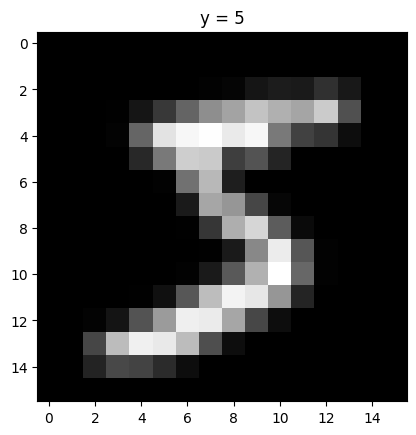

In [12]:
show_data(train_dataset[0])

In [13]:
train_dataset[0][1]

5

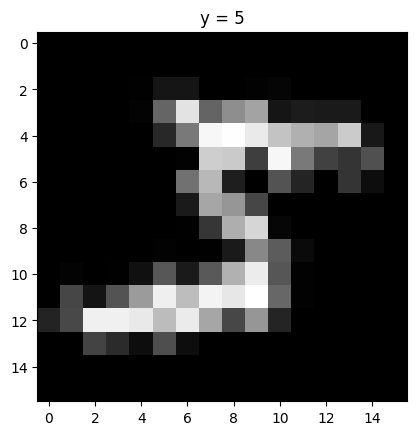

In [14]:
show_data(train_dataset_rotate[0])

In [15]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(
            in_channels=out_1,
            out_channels=out_2,
            kernel_size=5,
            stride=1, 
            padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out1,out

In [16]:
model = CNN(out_1=16, out_2=32)

In [17]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=5000)

In [19]:
file_normal = os.path.join(os.getcwd(), 'normal.pt')
checkpoint={
    'epoch': None,
    'model_state_dict': None,
    'optimizer_state_dict': None,
    'loss': None,
    'cost': [],
    'accuracy': []}
n_epochs = 5
n_test = len(validation_dataset)
for epoch in range(n_epochs):
    cost = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        checkpoint['epochs'] = n_epochs
        checkpoint['model_state_dict'] = model.state_dict()
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['loss'] = loss
        cost += loss.item()        
    correct = 0
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item() 
    accuracy = correct / n_test
    print(accuracy)
    checkpoint['cost'].append(cost) 
    checkpoint['accuracy'].append(accuracy)
    torch.save(checkpoint, file_normal) 

0.773
0.7843
0.7901
0.7966
0.7941


In [20]:
checkpoint_normal = torch.load(os.path.join(os.getcwd(),'normal.pt'))

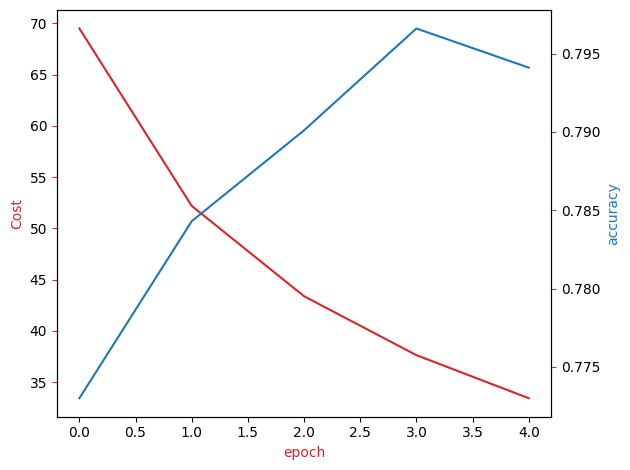

In [21]:
plot_cost_accuracy(checkpoint_normal)

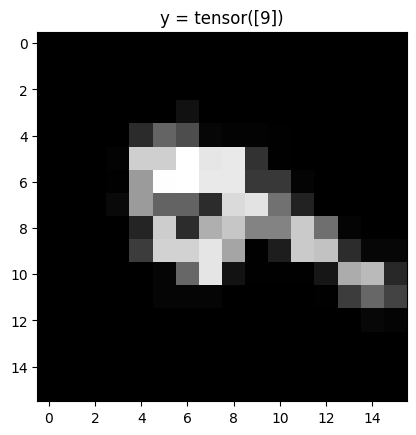

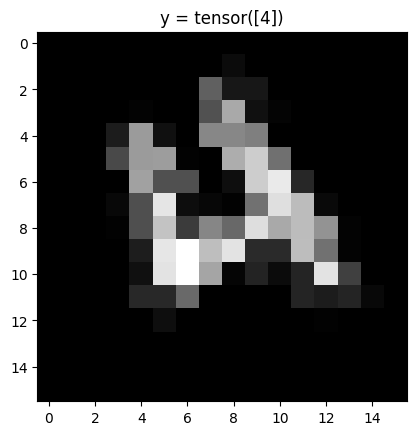

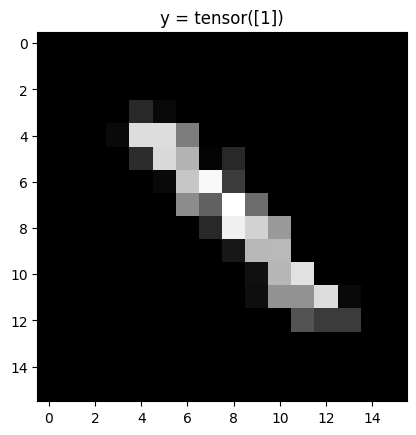

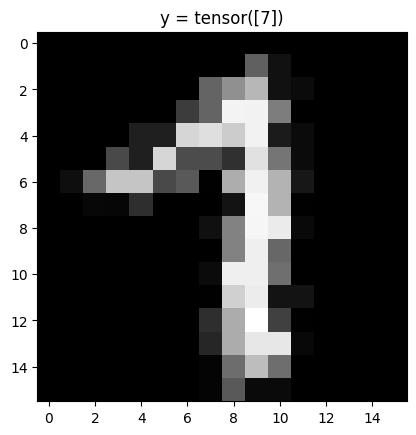

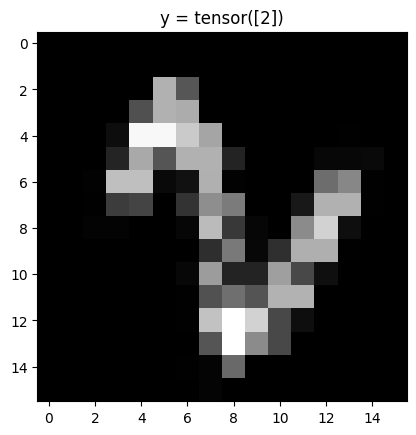

In [23]:
model.load_state_dict(checkpoint_normal['model_state_dict'])
model.eval()
plot_misclassified(model,validation_dataset)

In [24]:
model_r = CNN(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_rotate, batch_size=100)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=5000)

In [25]:
file_rotated = os.path.join(os.getcwd(), 'rotated_data.pt')
checkpoint={
    'epoch': None,
    'model_state_dict': None,
    'optimizer_state_dict': None,
    'loss': None,
    'cost': [],
    'accuracy': []}
n_epochs = 5
n_test = len(validation_dataset)
for epoch in range(n_epochs):
    cost = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model_r(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        checkpoint['epochs'] = n_epochs
        checkpoint['model_state_dict'] = model.state_dict()
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['loss'] = loss
        cost+=loss.item()
    correct = 0
    for x_test, y_test in validation_loader:
        z = model_r(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / n_test
    print(accuracy)
    checkpoint['cost'].append(cost) 
    checkpoint['accuracy'].append(accuracy)
    torch.save(checkpoint, file_rotated) 

0.9026
0.9269
0.9437
0.9485
0.9549


In [26]:
checkpoint_rotated= torch.load(
    os.path.join(os.getcwd(),'rotated_data.pt'))

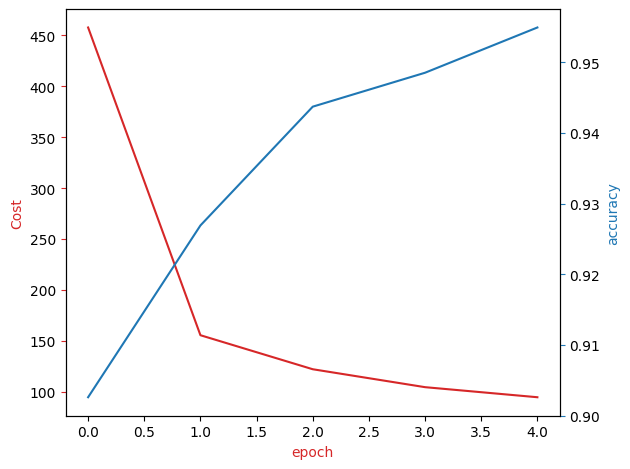

In [27]:
plot_cost_accuracy(checkpoint_rotated)

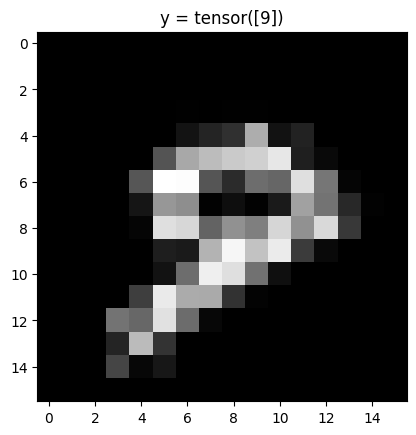

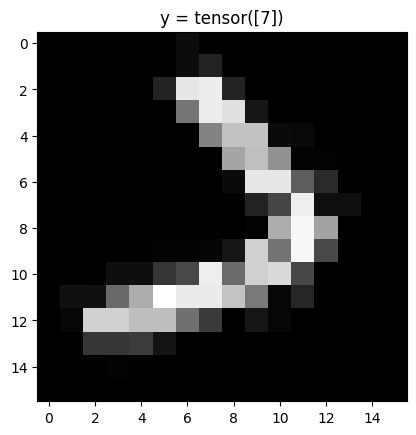

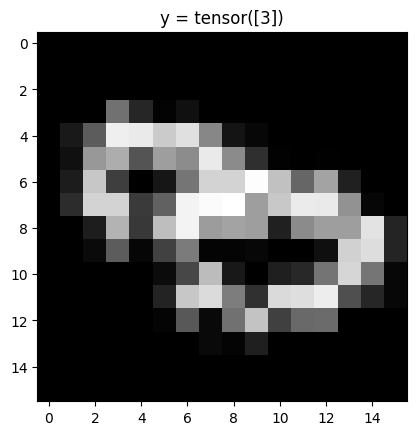

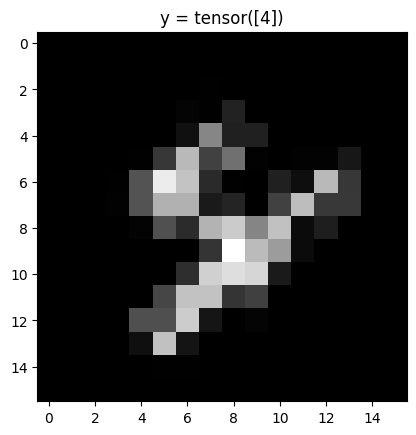

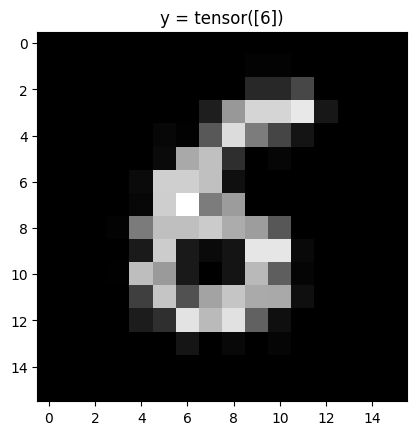

In [28]:
model_r.load_state_dict(checkpoint_rotated['model_state_dict'])
model.eval()
plot_misclassified(model_r,validation_dataset)